# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import gc
import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm

import scipy.sparse as sp

# Data Loading

In [2]:
PATH = '/kaggle/input/data/'

item_master = pd.read_csv(PATH + 'itemMasterData.csv')
data = pd.read_csv(PATH + 'train_dataset.csv')
test = pd.read_csv(PATH + 'test_users_final.csv')

In [3]:
rnm = {'userID': 'user_id',
       'itemID': 'item_id',
       'shopID': 'shop_id'}

data.rename(rnm, axis = 1, inplace = True) # it's a lot easier to type user_id rather than userID
item_master.rename(rnm, axis = 1, inplace=True)

In [4]:
data.head()

,user_id,item_id,day,shop_id,quantity
0,0,3,31,32,1.072
1,0,3,53,32,2.428
2,0,3,58,32,1.946
3,0,3,65,39,0.235
4,0,3,66,39,0.210


# EDA

In [5]:
def descr(data):
    """
    Some custom function that can be used as a first step in explorative analysis
    """
    print('*'*20 + '  DATA SHAPE  ' + '*'*20, '\n')
    print(f'Rows = {data.shape[0]:,} and Cols = {data.shape[1]:,}', '\n')
    print('*'*20 + '  UNIQUE RECORDS  ' + '*'*20, '\n')
    print(data.nunique(), '\n')
    print('*'*20 + '  BASIC INFO  ' + '*'*20, '\n')
    print(data.info(), '\n')
    print('*'*20 + '  DESCRIPTION  ' + '*'*20, '\n')
    print(data.describe(), '\n')
    
descr(data)

********************  DATA SHAPE  ******************** 

Rows = 37,631,450 and Cols = 5 

********************  UNIQUE RECORDS  ******************** 

user_id     275849
item_id      37038
day             84
shop_id         45
quantity     23993
dtype: int64 

********************  BASIC INFO  ******************** 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37631450 entries, 0 to 37631449
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   item_id   int64  
 2   day       int64  
 3   shop_id   int64  
 4   quantity  float64
dtypes: float64(1), int64(4)
memory usage: 1.4 GB
None 

********************  DESCRIPTION  ******************** 

            user_id       item_id           day       shop_id      quantity
count  3.763145e+07  3.763145e+07  3.763145e+07  3.763145e+07  3.763145e+07
mean   1.052141e+05  3.492669e+03  4.099642e+01  1.508745e+01  1.682284e+00
std    7.179697e+04  4.367826e+03  2.420288e+01  1.107032e+01  4

Above we can see basic information about the train dataset.

Firstly, it should be pointed out that we've __37.6M__ records. It means that we should be careful while wrangling the data, since we can kill our RAM. In my case, the RAM limitation was 8GB.

Secondly, we can see that the dataset was constructed by some part of __~275K__ users and __37K__ items interactions within __84 days__. Also, it seems like we have __45 different shops__. But more interestingly, $quantity$ column has only __23993__ unique values, which might imply that the data was obfuscated and actually we are dealing with discrete values rather than continuous ones.

Let the EDA begin


## Quantity

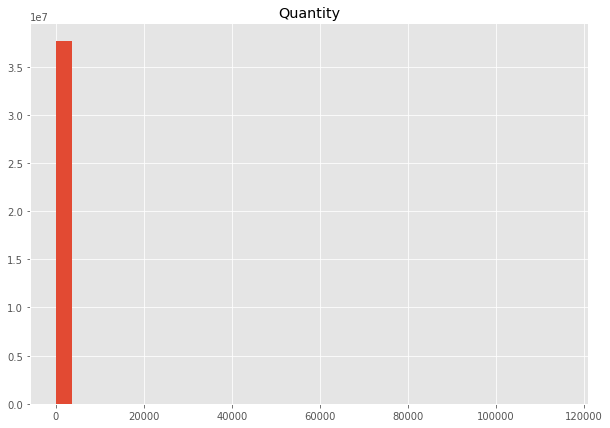

In [6]:
plt.figure(figsize = (10, 7))
data['quantity'].hist(bins = 30)
plt.title('Quantity');

Okay, we have some outliers in $quantity$. Let's look closer

In [7]:
data['quantity'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    3.763145e+07
mean     1.682284e+00
std      4.515984e+01
min      1.000000e-03
25%      1.000000e+00
50%      1.000000e+00
75%      1.972000e+00
90%      3.000000e+00
95%      4.000000e+00
99%      1.000000e+01
max      1.152010e+05
Name: quantity, dtype: float64

Yeap, 99% of values are less that 10, but there also some outliers like 115 201. 

Now let's look at histogram without outliers

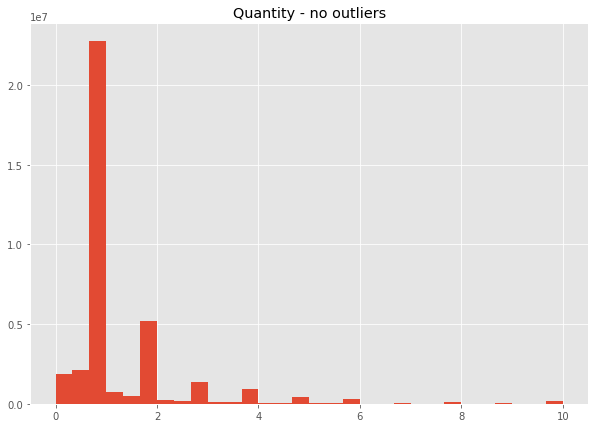

In [8]:
plt.figure(figsize = (10, 7))
data.loc[data['quantity'].between(0, 10), 'quantity'].hist(bins = 30)
plt.title('Quantity - no outliers');

Now it is more pretty. Also, the histogram reveals some bins that are more frequent than it's neighbors. Probably, it is due to discrete nature of the column that was obfuscated and mixed with some random noise

During the modeling we might want to remove the outliers

## Shop

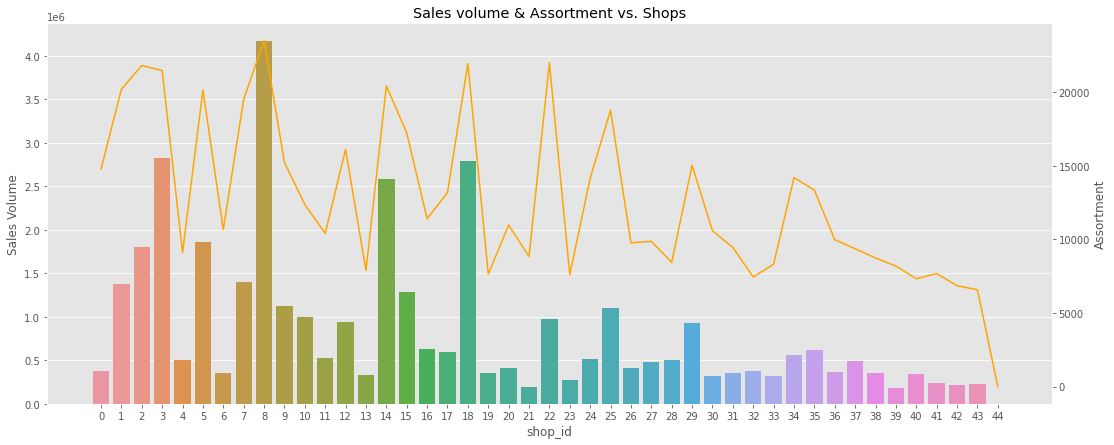

In [9]:
temp = data.groupby('shop_id').agg(SalesVolume = ('item_id', 'size'),
                                   Assortment = ('item_id', 'nunique'))

fig, ax1 = plt.subplots(figsize = (18, 7))
ax2 = ax1.twinx()
sns.barplot(x = temp.index, y = temp.SalesVolume, ax = ax1)
ax1.set_ylabel('Sales Volume')

ax2.plot(temp.index, temp.Assortment, color = 'orange')
ax2.grid(False)
ax2.set_ylabel('Assortment')

plt.title('Sales volume & Assortment vs. Shops');

The visualization above reveals sales volume of each shop and it's corresponding assortment of goods that are present in the dataset.

Barplot shows sales volume and orange line plot shows number of unique items. We can see that there is some correlation between assortment and sales volume. The shop that can offer huge number of items tend to have higher sales volume. 

In [10]:
del temp
gc.collect()

20

The code snippets like above will be used throughout this notebook, since it helps to delete from memory useless variables and free-up some memory by calling the garbage collector

## Day

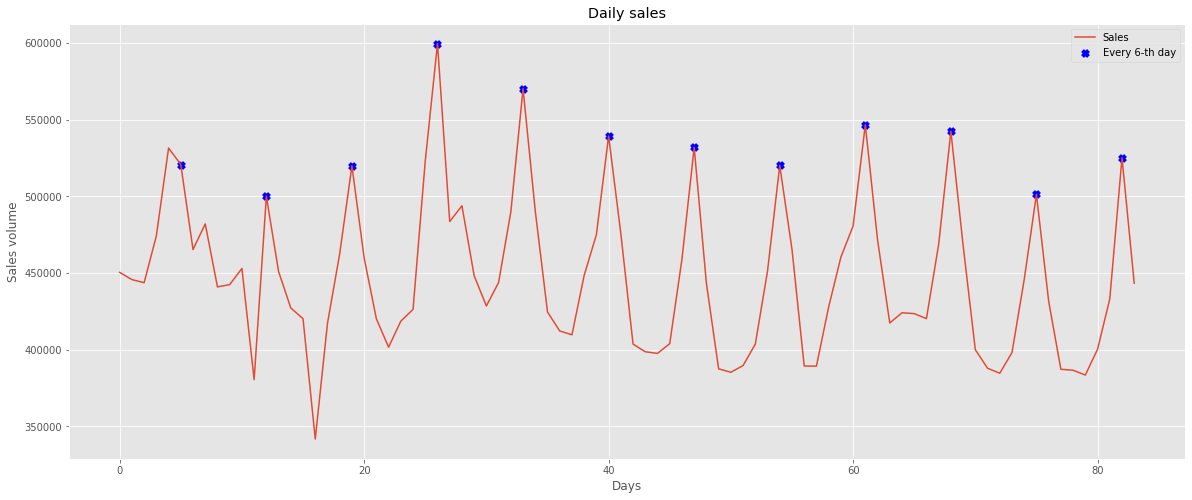

In [11]:
peaks = list(range(5, 83, 7))
sales_by_day = data.groupby('day').size()

plt.figure(figsize = (20, 8))
sales_by_day.plot()
plt.scatter(peaks, sales_by_day.loc[peaks], marker = 'x', color = 'b', linewidth = 4)
plt.title('Daily sales')
plt.ylabel('Sales volume')
plt.xlabel('Days')
plt.legend(['Sales', 'Every 6-th day']);

Now we can look at daily sales volume. The red line reveals daily sales volume and blue X mark illustrates the every 6-th day. The following things should be pointed out:
* __Saw Tooth Pattern:__ the graph above resembles the saw tooth. It actually means that there is some seasonality. Or in other words we have some cyclic trend that tends to repeat each N-days
* __Weekday Pattern:__ almost all of the blue X marks are located at the top of the saw tooth. It means that customers tend to shop each 6-th day. I think that the __"X days"__ are actually Saturdays. The dataset is provided by Magnum which is the leading hypermarket chain in Kazakhstan. Thus, Saturdays are the most popular day to purchase goods for the next week.

Let's create a new feature which will indicate the day of week


In [12]:
del sales_by_day
gc.collect()

3445

## Weekday

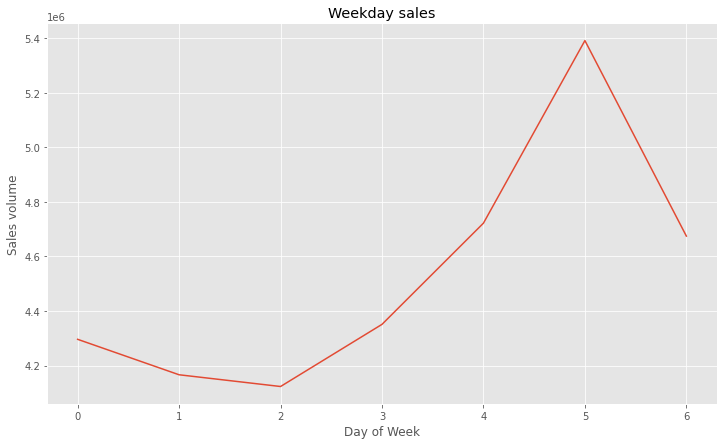

In [13]:
week_dict = dict(zip(list(range(70)), 
                     [i%7 for i in range(70)]))
data['weekday'] = data['day'].map(week_dict)

plt.figure(figsize = (12, 7))
data.groupby('weekday')\
    .size()\
    .plot()
plt.title('Weekday sales')
plt.ylabel('Sales volume')
plt.xlabel('Day of Week');

The visualization above reveals how sales distributed between weekdays. We can see that 6-th day has highest sales volume

# Validation

# Functions and utils

In [14]:
# metrics
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [15]:
# helps to remove the user history
def history_remover(data, hist_col, target_col):
    """
    IN:
        data -> dataframe with user_id as index, and columns that conctain list of items for each user
        hist_col -> name of column with history
        target_col -> name of column with items from which history should be removed
    OUT:
        dictionary: keys = user_ids, values = removed history
    """
    recs_dict = {}
    
    for idx in tqdm(data.index):
        user_recs = list(data.loc[idx, target_col])
        user_hist = list(data.loc[idx, hist_col])
        
        for x in user_hist:
            if x in user_recs:
                user_recs.remove(x)
        
        recs_dict[idx] = user_recs
        
    return recs_dict

# Validation

Okay, we have done some EDA.

However, more importantly we should set up train/validation process. We should be able to mimic the real evaluation process so that we can focus only on feature enginering and model fine-tunings

So, how can we get it done?

1. Take last 14 days (or 2 weeks) as a validation set
2. Then we need to leave only those users that are present in the train set
3. After we just need to remove the user history
4. Done!

In [16]:
train = data[data['day'].between(0, 69)]
valid = data[~data['day'].between(0, 69)]

In [17]:
common = set(train['user_id'].unique()) & set(valid['user_id'].unique()) 
historical = train.groupby('user_id')['item_id'].unique()

valid = valid.groupby('user_id')['item_id'].unique() #getting validation answers
valid = valid.loc[common] # leaving only users that are present in train
valid = valid[valid.apply(len) >= 10] # leaving only users that have 10 or more purchases
valid = pd.DataFrame(valid) 
valid['hist'] = historical.loc[valid.index].values # adding column with corresponding history

In [18]:
%%time
no_hist = history_remover(valid, 'hist', 'item_id')
valid['target'] = no_hist.values()

print('User history cleared!')

  0%|          | 0/157000 [00:00<?, ?it/s]

User history cleared!
CPU times: user 31.6 s, sys: 375 ms, total: 31.9 s
Wall time: 31.7 s


In [19]:
del common
del historical

gc.collect()

20

# Baseline

## Baseline #1
RecommendTOP10 popular items to each user

In [20]:
def baseline_1():
    top10 = train['item_id'].value_counts()\
                            .head(10)\
                            .index\
                            .values
    return train['item_id'].apply(lambda x: top10)

In [21]:
score_baseline_1 = mapk(valid['target'].values, baseline_1().values)
print(f'Baseline#1 score = {score_baseline_1:.5f}')

Baseline#1 score = 0.01664


On local validation it scored __0.01664__ and on leaderboard it had __0.02177__

## Baseline #2

In [22]:
def baseline_2():
    top1000 = train['item_id'].value_counts()\
                              .head(1000)\
                              .index\
                              .values
    
    valid['pop_rec'] = valid['item_id'].apply(lambda x: top1000)
    no_hist = history_remover(valid, 'hist', 'pop_rec')
    valid['pop_rec'] = no_hist.values()
    
    pop_sorter = train['item_id'].value_counts().to_dict()
    valid['pop_rec'] = valid['pop_rec'].apply(lambda arr: sorted(arr, 
                                                                 key = lambda x: pop_sorter[x], 
                                                                 reverse = True)[:10])
    print('Done!')

baseline_2()

  0%|          | 0/157000 [00:00<?, ?it/s]

Done!


In [23]:
pop_sorter = train['item_id'].value_counts().to_dict() # helps to sort items based on their popularity

valid['pop_rec'] = valid['pop_rec'].apply(lambda arr: sorted(arr, 
                                                      key = lambda x: pop_sorter[x], 
                                                      reverse = True)[:10])

In [24]:
score_baseline_2 = mapk(valid['target'].values, valid['pop_rec'].values)
print(f'Baseline#2 score = {score_baseline_2:.5f}')

Baseline#2 score = 0.03096


On local validation it scored __0.03096__ and on leaderboard it had __0.04695__. 

Now, it seems like we have legit baseline which can be afterwards compared with other models. By comparing we'll be able to judge if we are doing good or not

After this submission I have decided to track my hackathon progress. It helps to focus understand if the local validation is doing it's job and if we are doing good or not, obviously.

At this stage it looked like the following:

| Submit 	| Name       	|  Local  	| LeaderBoard 	| Ratio LB/Local 	| Coverage 	|
|:------:	|------------	|:-------:	|-------------	|----------------	|----------	|
|    1   	| Baseline#1 	| 0.01664 	| 0.02177     	| 1.31           	| 10       	|
|    2   	| Baseline#2 	| 0.03096 	| 0.04695     	| 1.51           	| 47      	|

# First try

In [25]:
users_inv_mapping = dict(enumerate(train['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
print(f'{len(users_mapping):,} users are mapped')

items_inv_mapping = dict(enumerate(train['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
print(f'{len(items_mapping):,} items are mapped')

274,124 users are mapped
35,879 items are mapped


In [26]:
import scipy.sparse as sp

def get_coo_matrix(df, 
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None, 
                   users_mapping=users_mapping, 
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype = np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.recommend(user_id, 
                               train_matrix, 
                               N = N, 
                               filter_already_liked_items =True)
        return [item_inv_mapping[item] for item, _ in recs]
    return _recs_mapper

__get_coo_matrix()__ does the following:
1. Takes user_ids as a rows
2. Takes item_ids as a columns
3. Puts weights (if not provided, then just 1) in to corresponding coordinates of (row, col)

For, example we have users 0,1,2 and items 0,1,2 with weights 1. Let's say that we had some interactions b/w them. For example, user_0 bought item_1 and user_2 bought item_2. Then, 

|           	| item_0 	| item_1 	| item_2 	|
|:------------: |:------:	|:--------: |:------:	|
| __user_0__ 	|    0   	| 1      	|    0   	|
| __user_1__ 	|    0   	| 0      	|    0   	|
| __user_2__ 	|    0   	| 0      	|    1   	|


__generate_implicit_recs_mapper()__ is a helper function that generates user recommendations

In [27]:
%%time

train_mat = get_coo_matrix(train).tocsr()
train_mat

CPU times: user 58.8 s, sys: 806 ms, total: 59.6 s
Wall time: 59.3 s


<274124x35879 sparse matrix of type '<class 'numpy.float32'>'
	with 23285873 stored elements in Compressed Sparse Row format>

So, in the train set we have 274,124 users and 35,879. If we wanted to create user-item interactions dataset, then we would have 35,879 * 274,124 = 9,835,294,996 interactions. And if we were about to store it as a pandas.DataFrame, then we would never be able store it on a local machine.

Thus, we use scipy's sparse matrix to store only 23,285,873 non-zero elements which is about 500 times less elements.

I have experimented with a lot of ready-to-use Python modules that offer some RecommenderSystem solutions.
But majority of them just didn't workout due to various number of reasons. Here are some of them:
* __LightFM__ is a Python implementation of a number of popular recommendation algorithms for both implicit and explicit feedback, including efficient implementation of BPR and WARP ranking losses. It's easy to use, fast (via multithreaded model estimation), and produces high quality results. It also makes it possible to incorporate both item and user metadata into the traditional matrix factorization algorithms. It represents each user and item as the sum of the latent representations of their features, thus allowing recommendations to generalise to new items (via item features) and to new users (via user features). [LINK](https://github.com/lyst/lightfm) - This module didn't workout for me due to hardware limitations. It was really slow on CPU and I wasn't able make it work on GPU, however, I believe that it would have done good job, since it can use item and user features, thus some good feature engineering would have increased the model performance
* __Implicit.ALS__ is a Recommendation Model based off the algorithms described in the paper _‘Collaborative Filtering for Implicit Feedback Datasets’_ with performance optimizations described in _‘Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering'_. [LINK](https://implicit.readthedocs.io/en/latest/als.html). - this model also didn't work out due to hardware limitaions. It was really slow. One model training was taking about 3-4 hours.
* __sklearn.NearestNeighbors__ - submodule of scikit-learn. I was trying to find similar users and recommend based on these items from those users' history. Also, tried to model recommendation based on item similarities. However, none of the approaches was not better than the baseline model [LINK](https://scikit-learn.org/stable/modules/neighbors.html)
* __Spotligh__ - uses PyTorch to build both deep and shallow recommender models. By providing both a slew of building blocks for loss functions (various pointwise and pairwise ranking losses), representations (shallow factorization representations, deep sequence models), and utilities for fetching (or generating) recommendation datasets, it aims to be a tool for rapid exploration and prototyping of new recommender models. [LINK](https://github.com/maciejkula/spotlight). - Was not able to achieve good performance on it
* __Implicit.nearest_neighbours__ - best in sense of performance & speed. It showed one of the best results during experimentations stage and really easy to use. Also, functions work really fast, those easy to check hypotheses and fine-tune the final model

I have decided to stop on __Implicit.nearest_neighbors__. The module can only work with user-item interaction matrix. It has base 3 recommenders and they are:
1. CosineRecommender - it uses cosine similarity as a distance function to recommend items
2. BM25Recommender - it uses some custom function called Okapi BM25 to rank relevant items. [More](https://en.wikipedia.org/wiki/Okapi_BM25)
3. TFIDFRecommender - it uses widely known in NLP method called TFIDF

Now let's check which method works better on our dataset and fine-tune it. We can tune:
* K - number of neighbors
* weight - weight that will be used in user-item matrix
* shape - collection of users & items to use

In [28]:
from implicit.nearest_neighbours import CosineRecommender

tune_dict = {}

scores = []
for k in range(1, 100, 5):
    model = CosineRecommender(K = k)
    model.fit(train_mat.T)

    mapper = generate_implicit_recs_mapper(model, 
                                           train_mat, 
                                           10, 
                                           users_mapping, 
                                           items_inv_mapping)

    recs = pd.DataFrame({
        'user_id': valid.index
    })
    recs['item_id'] = recs['user_id'].map(mapper)

    score = mapk(valid['target'], recs['item_id'])
    scores.append(score)
    
tune_dict['cosine'] = scores

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

In [29]:
from implicit.nearest_neighbours import TFIDFRecommender

scores = []
for k in range(1, 100, 5):
    model = TFIDFRecommender(K = k)
    model.fit(train_mat.T)

    mapper = generate_implicit_recs_mapper(model, 
                                           train_mat, 
                                           10, 
                                           users_mapping, 
                                           items_inv_mapping)

    recs = pd.DataFrame({
        'user_id': valid.index
    })
    recs['item_id'] = recs['user_id'].map(mapper)

    score = mapk(valid['target'], recs['item_id'])
    scores.append(score)
    
tune_dict['tfidf'] = scores

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

In [30]:
from implicit.nearest_neighbours import BM25Recommender

scores = []
for k in range(1, 100, 5):
    model = BM25Recommender(K = k)
    model.fit(train_mat.T)

    mapper = generate_implicit_recs_mapper(model, 
                                           train_mat, 
                                           10, 
                                           users_mapping, 
                                           items_inv_mapping)

    recs = pd.DataFrame({
        'user_id': valid.index
    })
    recs['item_id'] = recs['user_id'].map(mapper)

    score = mapk(valid['target'], recs['item_id'])
    scores.append(score)
    
tune_dict['bm25'] = scores

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

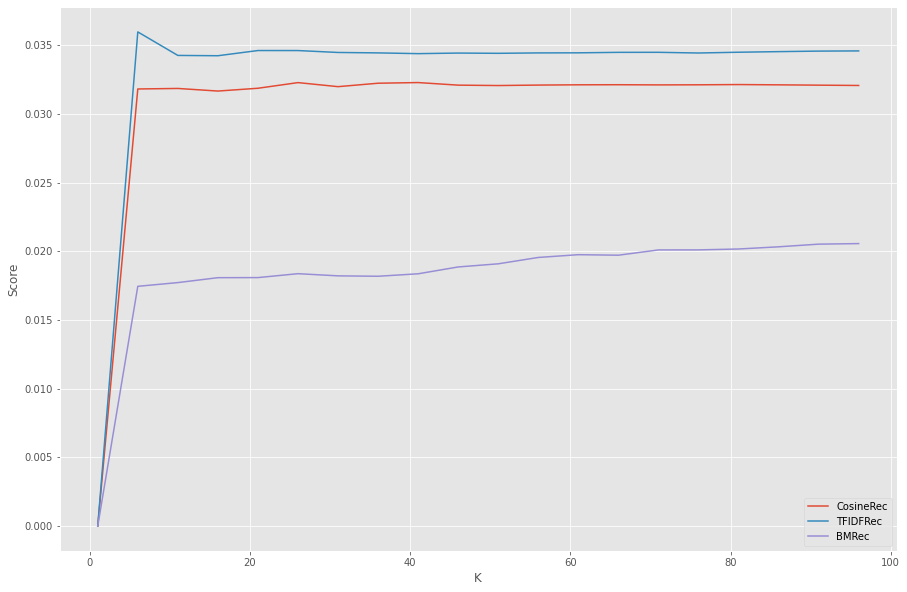

In [31]:
ks = list(range(1, 100, 5))

plt.figure(figsize = (15, 10))
plt.plot(ks, tune_dict['cosine'], label = 'CosineRec')
plt.plot(ks, tune_dict['tfidf'], label = 'TFIDFRec')
plt.plot(ks, tune_dict['bm25'], label = 'BMRec')
plt.ylabel('Score')
plt.xlabel('K')
plt.legend();

Here we can see that __TFIDF__ outperforms __Cosine__ and __BM25 recommenders__.

Some can argue that __BM25__ needs more neighbors, however, it converges on 0.28

Now, without any doubt we can work with __TFIDF__ only. We just need to finetune it.
1. Choose better K. The highest score was achieved between 1 and 10
2. Choose better weight. Now we are just using 1 as an indicator of user-item interaction. We can assign some custom weights to increase the score

## Choosing K

Before choosing the optimal __K__, I actually had a submission which had local score of __0.03474__ and LB score of __0.05462__.

At this stage my progress table looked as following

| Submit 	| Name       	|  Local  	| LeaderBoard 	| Ratio LB/Local 	| Coverage 	|
|:------:	|------------	|:-------:	|-------------	|----------------	|----------	|
|    1   	| Baseline#1 	| 0.01664 	| 0.02177     	| 1.31           	| 10       	|
|    2   	| Baseline#2 	| 0.03096 	| 0.04695     	| 1.51           	| 47      	|
|    3      | TFIDF (K = 25)| 0.03474   | 0.05462       | 1.57              |           |

I was really happy, since I was able to beat the baseline model on intermediate users. Also, I was seeing positive correlation between my local score and LeaderBoard score. It meant that I can trust my local validation and can expect score of __1.5 x Local score__ on the LeaderBoard

In [32]:
scores = []
for k in range(1, 15):
    model = TFIDFRecommender(K = k)
    model.fit(train_mat.T)

    mapper = generate_implicit_recs_mapper(model, 
                                           train_mat, 
                                           10, 
                                           users_mapping, 
                                           items_inv_mapping)

    recs = pd.DataFrame({
        'user_id': valid.index
    })
    recs['item_id'] = recs['user_id'].map(mapper)

    score = mapk(valid['target'], recs['item_id'])
    scores.append(score)

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

  0%|          | 0/35879 [00:00<?, ?it/s]

Highest score = 0.03620 was achieved at K = 5


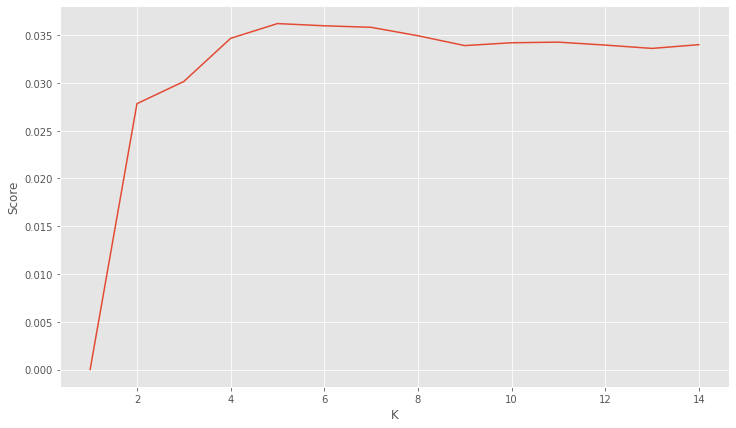

In [33]:
max_score = max(scores)
max_index = scores.index(max_score) + 1

print(f'Highest score = {max_score:.5f} was achieved at K = {max_index}')
plt.figure(figsize = (12, 7))
plt.plot(range(1, 15), scores)
plt.ylabel('Score')
plt.xlabel('K');

__TFIDF__, short for __term frequency–inverse document frequency__, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. You can read more [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In our case, __TFIDF__ reflects how important an item is to an user in the collection of Magnum customers

TFIDF works better than Cosine recommender, since TFIDF captures information about the item popularity and relevance of an item to the user.

After choosing optimal K, I have done my next submission after which my progress table changed to:

| Submit 	| Name       	|  Local  	| LeaderBoard 	| Ratio LB/Local 	| Coverage 	|
|:------:	|------------	|:-------:	|-------------	|----------------	|----------	|
|    1   	| Baseline#1 	| 0.01664 	| 0.02177     	| 1.31           	| 10       	|
|    2   	| Baseline#2 	| 0.03096 	| 0.04695     	| 1.51           	| 47      	|
|    3      | TFIDF (K = 25)| 0.03474   | 0.05462       | 1.57              |           |
|    4      | TFIDF (K = 6) | 0.03620   | 0.05764       | 1.59              | 3353      |

Again we can see stable correlation between local validation score and LB score. Also, it should be pointed out that coverage is wide. If base models were choosing their recommendations out of ~50 items, but now TFIDFRecommender showing better performance and covering 3353 items. It indicates that our model was able to retrieve some useful information and recommend relatively good items for each user

## New weights

During the EDA process I had an idea of regarding $quantity$ as a rating given to an item by an user.

If an user purchases at some time a particular item, then it means that he/she liked it. In that sense, quantity purchased seems to be relatable

That's why I have decided to use quantities as weights

In [34]:
train['qty_clipped'] = np.clip(train['quantity'], 0, 10) #removing outliers

train_mat_qty = get_coo_matrix(train, weight_col = 'quantity').tocsr()

In [35]:
model = TFIDFRecommender(K = 5)
model.fit(train_mat_qty.T)

mapper = generate_implicit_recs_mapper(model, 
                                       train_mat_qty, 
                                       10, 
                                       users_mapping, 
                                       items_inv_mapping)

recs = pd.DataFrame({
    'user_id': valid.index
})
recs['item_id'] = recs['user_id'].map(mapper)

score = mapk(valid['target'], recs['item_id'])
print(f'Score = {score:.5f}')

  0%|          | 0/35879 [00:00<?, ?it/s]

Score = 0.02841


Okay, that didn't workout :)
Now, let's try to do some magic

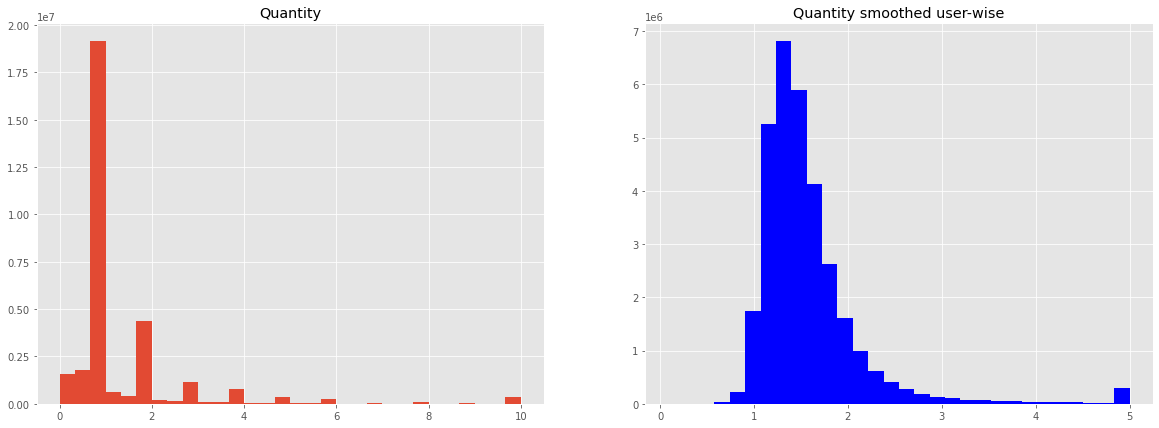

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
np.clip(train['quantity'], 0, 10).hist(ax = ax[0], bins = 30)
ax[0].set_title('Quantity')

train['qty_smoothed'] = train.groupby('user_id')['quantity'].transform('mean')
train['qty_smoothed'] = np.clip(train['qty_smoothed'], 0, 5)
train['qty_smoothed'].hist(ax = ax[1], color = 'b', bins = 30)
ax[1].set_title('Quantity smoothed user-wise');

The next idea was to somehow smoothen $quantity$ column. Thus, I have decided to create new column called __qty_smoothed__ which is just user-wise mean values for quantity with upper bound at 5.

__qty_smoothed__ actually reflects some user behaviours. With the help of it we can distinguish purchasing power levels and maybe will be able to retrieve user similarities

In [37]:
train_mat_qty_smoothed = get_coo_matrix(train, weight_col = 'qty_smoothed').tocsr()
model = TFIDFRecommender(K = 6)
model.fit(train_mat_qty_smoothed.T)

mapper = generate_implicit_recs_mapper(model, 
                                       train_mat_qty_smoothed, 
                                       10, 
                                       users_mapping, 
                                       items_inv_mapping)

recs = pd.DataFrame({
    'user_id': valid.index
})
recs['item_id'] = recs['user_id'].map(mapper)

score = mapk(valid['target'], recs['item_id'])
print(f'Score = {score:.5f}')

  0%|          | 0/35879 [00:00<?, ?it/s]

Score = 0.03615


Okay, now it looks a lot better, but anyways not ideal. It's leaderbord score was nearly ~0.058

I was trying to create some other new features to use as weights, however, nothing was increasing model performance.
Lastly, I was experimenting with day-related features and found out that using just __day__ column as weights works a lot better :)

In [38]:
train_mat_day = get_coo_matrix(train, weight_col = 'day').tocsr()
model = TFIDFRecommender(K = 6)
model.fit(train_mat_day.T)

mapper = generate_implicit_recs_mapper(model, 
                                       train_mat_day, 
                                       10, 
                                       users_mapping, 
                                       items_inv_mapping)

recs = pd.DataFrame({
    'user_id': valid.index
})
recs['item_id'] = recs['user_id'].map(mapper)

score = mapk(valid['target'], recs['item_id'])
print(f'Score = {score:.5f}')

  0%|          | 0/35879 [00:00<?, ?it/s]

Score = 0.04211


That was my final solution and it scored __0.06091__ on the final LeaderBoard

Why using __day__ columns as weights works better? Probably, it works better since days can represent user behaviours, items similarity, users similarity, cohorts, and bunch of other things. Thus, by embeding additional user-item information to TFIDF, we get the model that has better understanding of what's going on

# Didn't work out

* Considering users' purchase history as a text, then trying to predict next token using NLP methods
* Considering users' purchase history as a text, then feeding it to CatBoost with other many features
* Ranking. When I was generating by 100 recommendation for each user, then on average I had ~20% intersection with the target. In other words, proper ranking and selecting top-10 relevant would have done the job. Unfortunately, was not able to make it work!
* 2-nd stage classifier. Classes were highly imbalanced. Tree based models were dealing good in comparison with others, however still not sufficiently good. With CatBoost were able to get an uplift of __+0.005+__, however next time was not able to reproduce it, since 8 GB RAM was being killed over and over,
* Blending results - probably due to high correlation
* LightFM with user & item features - due to lack of hardware
* ALS - due to lack of hardware
* Using only items with minimum occurence of 100, 500, 1000, 5000
* etc.

# Wanted to test out, but wasn't able to

* Build separate models for each homogeneous cluster of users (e.g. same shop, same cohort, same behaviour, etc.)
* Deep models